In [1]:
import pandas as pd
import numpy as np

import torch
from numpy import zeros, newaxis

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.stats import zscore
import re
import os


import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.datasets import make_spd_matrix
from scipy.sparse import random

import math
torch.autograd.set_detect_anomaly(True)
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn import model_selection

# **Data input**

In [2]:
## uncomment for Friedman regression problem
# df = pd.read_csv('Synthetic_Data_friedman1_100noise_01.csv')
# m = 100


## uncomment for Linear regression with tail = 0.2
# df = pd.read_csv('Synthetic_Data_regression_100noise_03_tail02.csv')
# m = 100


## uncomment for Linear regression with tail = 0.7
df = pd.read_csv('Synthetic_Data_regression_100noise_03_tail07.csv')
m = 100





x_input = df.iloc[:,0:m].to_numpy()
y_output = df.iloc[:,m].to_numpy()

# Import GNN libraries

In [3]:
import Modules.architectures as archit
import Utils.graphML as gml

In [4]:
nTotal = y_output.shape[0]
idxTotal = np.random.permutation(nTotal)
idxTest = idxTotal[np.floor(0.9*nTotal).astype(int):]
idxTrain = idxTotal[0:np.floor(0.8*nTotal).astype(int)]
idxValid = idxTotal[np.floor(0.8*nTotal).astype(int):np.floor(0.9*nTotal).astype(int)]
idx_train = np.concatenate([idxTrain, idxValid])
n_all_train = len(idx_train)

Xtrain = torch.tensor(zscore(x_input[idx_train,:].T,axis=1)) # training set
Xtest = torch.tensor(zscore(x_input[idxTest,:].T,axis=1)) # test set
y = torch.tensor(y_output)
C = torch.cov(Xtrain)




# Compare VNN and PCA-regression models

In [5]:

perms = 100 # number of nominal models

Loss = nn.MSELoss()
GNN_list = []
pca_list = []
df_perf = pd.DataFrame( columns=['Perm', 'Valid_perf_MAE', 'Valid_perf_corr',
                                    'Test_perf_MAE','Test_perf_corr', 'All_perf_MAE', 'All_perf_corr' , 'PCA_ncomps', 'PCA_test_perf_MAE', 'PCA_test_perf_corr'
                               , 'PCA_all_perf_MAE', 'PCA_all_perf_corr','PCA_ncomps_rbf', 'PCA_test_perf_MAE_rbf', 'PCA_test_perf_corr_rbf'
                               , 'PCA_all_perf_MAE_rbf', 'PCA_all_perf_corr_rbf'])


df_smpls_perf = pd.DataFrame(columns=['Perm','samples',
                                'Test_perf_MAE','Test_perf_corr', 'All_perf_MAE', 'All_perf_corr', 'PCA_test_perf_MAE', 'PCA_test_perf_corr'
                               , 'PCA_all_perf_MAE', 'PCA_all_perf_corr'])

nEpochs = 100
for perm in range(perms):

    idx_train = np.random.permutation(n_all_train)
    idxTrain = idx_train[0:np.floor(0.88*n_all_train).astype(int)]
    idxValid = idx_train[np.floor(0.88*n_all_train).astype(int)+1:np.floor(n_all_train).astype(int)]
    nTest = int(np.floor(0.1*nTotal))
    nTrain = idxTrain.shape[0]


    xTrain = Xtrain[:,idxTrain]
    xTrain = torch.tensor(np.expand_dims(xTrain, axis=1))
    yTrain = y[idxTrain]

    xTest = Xtest
    xTest = torch.tensor(np.expand_dims(xTest, axis=1))
    yTest = y[idxTest]

    xValid = Xtrain[:,idxValid]
    xValid = torch.tensor(np.expand_dims(xValid, axis=1))
    yValid = y[idxValid]

    
    ## GNN nominal model
    GNN1Ly = archit.SelectionGNN([1,13,13], [2,2], True, nn.ReLU, [m,m], 
                                   gml.NoPool, [1,1], [1], C)

    batchSize = 40
    if nTrain < batchSize:
        nBatches = 1
        batchSize = [nTrain]
    elif nTrain % batchSize != 0:
        nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
        batchSize = [batchSize] * nBatches
        while sum(batchSize) != nTrain:
            batchSize[-1] -= 1
    else:
        nBatches = np.int(nTrain/batchSize)
        batchSize = [batchSize] * nBatches
    batchIndex = np.cumsum(batchSize).tolist()
    batchIndex = [0] + batchIndex

    MAE = nn.L1Loss()
    lossTrain = []
    costTrain = []
    lossValid = []
    costValid = []
    optimizer = optim.Adam(GNN1Ly.parameters(), lr=  0.015088624679989619)
    epoch = 0
    Best_Valid_Loss = 100
    while epoch < nEpochs:
        randomPermutation = np.random.permutation(nTrain)
        idxEpoch = [int(i) for i in randomPermutation]

        batch = 0 

        j = 0
        acc_b = 0
        while batch < nBatches:
            clear_output(wait=True)
            thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
            xTrainBatch = xTrain[:,:,thisBatchIndices].T
            yTrainBatch = yTrain[thisBatchIndices].unsqueeze(0)
            GNN1Ly.zero_grad()
            yHatTrainBatch = GNN1Ly(xTrainBatch[:,:,:])
            lossValueTrain = Loss((yHatTrainBatch) , yTrainBatch.T)
            lossValueTrain.backward()
            optimizer.step()
            batch+=1
        with torch.no_grad():
            yHatValid = GNN1Ly(xValid[:,:,:].T)
            yHatTrain = GNN1Ly(xTrain[:,:,:].T)

            Valid_Loss = MAE((yHatValid) , yValid.unsqueeze(0).T)

            if Valid_Loss < Best_Valid_Loss:
                Best_Valid_Loss = Valid_Loss
                Best_GNN = GNN1Ly

           

        epoch+=1
        
    GNN_list.append(Best_GNN)
  
    yBestValid = Best_GNN(xValid[:,:,:].T)
    yBestTest = Best_GNN(xTest[:,:,:].T)
    yBestTrain = Best_GNN(xTrain[:,:,:].T)

    ## PCA-LR nominal model
    eig_values, eig_vectors = torch.eig(C,eigenvectors=True)
    for i in range(eig_vectors.shape[0]):
        if eig_vectors[0,i]<0:
            eig_vectors[:,i] = -eig_vectors[:,i]
    
    sortedEig, indices=torch.sort(eig_values, dim=0, descending=True, out=None)
    
    eig_vectors = eig_vectors[:,indices[:,0]]

    svr = SVR(kernel='linear')
    cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
    mse = []
    X_reduced = torch.matmul(eig_vectors.T , xTrain.squeeze()).T

    for i in np.arange(1, 20):
        score = -1*model_selection.cross_val_score(svr,
                   X_reduced[:,:i], yTrain, cv=cv, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
        mse.append(score)


    ncomps_pca = np.argmin(mse) + 1
    svr = SVR(kernel='linear')
    X_test_reduced = torch.matmul(eig_vectors.T , xTest.squeeze()).T
    X_test_reduced = X_test_reduced[:,:ncomps_pca]
    pca_test_mdl = svr.fit(X_reduced[:,:ncomps_pca], yTrain)
    pred_ytest =  svr.predict(X_test_reduced)
    best_pca_score = MAE(torch.tensor(pred_ytest), yTest)
    svr = SVR(kernel='linear')
    X_train_reduced =  torch.matmul(eig_vectors.T , xTrain.squeeze()).T
    X_train_reduced = X_train_reduced[:,:ncomps_pca]
    pca_mdl = svr.fit(X_reduced[:,:ncomps_pca], yTrain)
    pred_ytrain =  pca_mdl.predict(X_train_reduced)
    train_pca_score = MAE(torch.tensor(pred_ytrain), yTrain)
    
    
    
    ## PCA-rbf nominal model
    svr_rbf = SVR(kernel='rbf')
    cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
    mse = []
    X_reduced = torch.matmul(eig_vectors.T , xTrain.squeeze()).T

    for i in np.arange(1, 50):
        score = -1*model_selection.cross_val_score(svr_rbf,
                   X_reduced[:,:i], yTrain, cv=cv, scoring='neg_mean_absolute_error',n_jobs=-1).mean()
        mse.append(score)


    ncomps_pca_rbf = np.argmin(mse) + 1
    svr_rbf = SVR(kernel='rbf')
    X_test_reduced = torch.matmul(eig_vectors.T , xTest.squeeze()).T
    X_test_reduced = X_test_reduced[:,:ncomps_pca_rbf]
    svr_rbf.fit(X_reduced[:,:ncomps_pca_rbf], yTrain)
    pred_ytest_rbf =  svr_rbf.predict(X_test_reduced)
    best_pca_score_rbf = MAE(torch.tensor(pred_ytest_rbf), yTest)
    svr_rbf = SVR(kernel='rbf')
    X_train_reduced_rbf =  torch.matmul(eig_vectors.T , xTrain.squeeze()).T
    X_train_reduced_rbf = X_train_reduced_rbf[:,:ncomps_pca_rbf]
    pca_mdl_rbf = svr_rbf.fit(X_reduced[:,:ncomps_pca_rbf], yTrain)
    pred_ytrain_rbf =  pca_mdl_rbf.predict(X_train_reduced_rbf)
    train_pca_score_rbf = MAE(torch.tensor(pred_ytrain_rbf), yTrain)
    
    # store VNN, PCA-LR and PCA-rbf performance metrics
    df_new_row = pd.DataFrame(data=np.array([[perm,MAE(yBestValid,yValid.unsqueeze(0).T ).detach(),
                                                  MAE(yBestTest,yTest.unsqueeze(0).T ).detach(),
                                                 MAE(yBestTrain,yTrain.unsqueeze(0).T ).detach(),
                                                 ncomps_pca, best_pca_score, train_pca_score,
                                              ncomps_pca_rbf, best_pca_score_rbf, train_pca_score_rbf
                                                 ]]), 
                                  columns=['Perm', 'Valid_perf_MAE',
                                    'Test_perf_MAE', 'Train_perf_MAE' , 'PCA_ncomps', 'PCA_test_perf_MAE',
                                'PCA_train_perf_MAE','PCA_ncomps_rbf', 'PCA_test_perf_MAE_rbf'
                               , 'PCA_train_perf_MAE_rbf'])
    

    
    df_perf = pd.concat([df_perf,df_new_row], ignore_index=True)
     
    
    ## Stability analysis
    
    for smpls in range(10,900, 10):
        with torch.no_grad():
            smpls_perm = np.random.permutation(smpls)
            C_t =  torch.cov(Xtrain[:,range(smpls)]) # perturbed covariance matrix

            w,v = np.linalg.eig(C_t)
            
            # VNN that imports weights/parameters from the nominal model
            GNN_t = archit.SelectionGNN([1,13,13], [2,2], True, nn.ReLU, [m,m], 
                                       gml.NoPool, [1,1], [1], C_t)

            GNN_t.GFL.load_state_dict(GNN_list[perm].GFL.state_dict())
            GNN_t.MLP.load_state_dict(GNN_list[perm].MLP.state_dict())
            yHatTest_t = GNN_t(xTest[:,:,:].T)
            ytrain_t = GNN_t(xTrain[:,:,:].T)
            
            # Re-evaluate principal components
            eig_values_t, eig_vectors_t = torch.eig(C_t,eigenvectors=True)
            for i in range(eig_vectors_t.shape[0]):
                if eig_vectors_t[0,i]<0:
                    eig_vectors_t[:,i] = -eig_vectors_t[:,i]
            sortedEig_t, indices=torch.sort(eig_values_t, dim=0, descending=True, out=None)
            eig_vectors_t = eig_vectors_t[:,indices[:,0]]

            # PCA-LR performance with perturbed principal components
            X_test_reduced_t = torch.matmul(eig_vectors_t.T , xTest.squeeze()).T
            X_test_reduced_t = X_test_reduced_t[:,:ncomps_pca]
            pred_ytest_t =  pca_mdl.predict(X_test_reduced_t)
            pca_test_score_t = MAE(torch.tensor(pred_ytest_t), yTest)
            X_train_reduced_t =  torch.matmul(eig_vectors_t.T , xTrain.squeeze()).T
            X_train_reduced_t = X_train_reduced_t[:,:ncomps_pca]
            pred_ytrain_t =  pca_mdl.predict(X_train_reduced_t)
            train_pca_score_t = MAE(torch.tensor(pred_ytrain_t), yTrain)
            
            # PCA-rbf performance with perturbed principal components
            X_test_reduced_t_rbf = torch.matmul(eig_vectors_t.T , xTest.squeeze()).T
            X_test_reduced_t_rbf = X_test_reduced_t_rbf[:,:ncomps_pca_rbf]
            pred_ytest_t_rbf =  pca_mdl_rbf.predict(X_test_reduced_t_rbf)
            pca_test_score_t_rbf = MAE(torch.tensor(pred_ytest_t_rbf), yTest)
            X_train_reduced_t_rbf =  torch.matmul(eig_vectors_t.T , xTrain.squeeze()).T
            X_train_reduced_t_rbf = X_train_reduced_t_rbf[:,:ncomps_pca_rbf]
            pred_ytrain_t_rbf =  pca_mdl_rbf.predict(X_train_reduced_t_rbf)
            train_pca_score_t_rbf = MAE(torch.tensor(pred_ytrain_t_rbf), yTrain)

            
            # store VNN, PCA-LR and PCA-rbf performance metrics for stability analysis
            df_new_row_t = pd.DataFrame(data=np.array([[perm,smpls,
                                                      MAE(yHatTest_t,yTest.unsqueeze(0).T ).detach(),
                                                     MAE(ytrain_t,yTrain.unsqueeze(0).T ).detach(),
                                                     ncomps_pca, pca_test_score_t, train_pca_score_t,
                                                        ncomps_pca_rbf, pca_test_score_t_rbf, train_pca_score_t_rbf
                                                     ]]), 
                                     columns=['Perm','samples',
                                    'Test_perf_MAE', 'Train_perf_MAE', 'ncomps_pca','PCA_test_perf_MAE'
                                   , 'PCA_train_perf_MAE','ncomps_pca_rbf','PCA_test_perf_MAE_rbf'
                                   , 'PCA_train_perf_MAE_rbf'])
            df_smpls_perf = pd.concat([df_smpls_perf,df_new_row_t], ignore_index=True)
            




print("")

# Visualization of results

In [6]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
df_cmp = df_smpls_perf


# Performance on training set
VNN_trainperf_MAE_all = []  # VNN performance
PCA_trainperf_MAE_all = []  # PCA-LR performance
PCA_trainperf_MAE_all_rbf = [] # PCA-rbf performance


# Performance on test set
VNN_testperf_MAE_all = []  # VNN performance
PCA_testperf_MAE_all = []  # PCA-LR performance
PCA_testperf_MAE_all_rbf = []  # PCA-rbf performance

for smpls in range(50,900,10):
    df_perf_sm = df_cmp[df_cmp['samples'] == smpls]
    VNN_trainperf_MAE_all.append([df_perf_sm['Train_perf_MAE'].mean()])
    PCA_trainperf_MAE_all.append([df_perf_sm['PCA_train_perf_MAE'].mean()])
    PCA_trainperf_MAE_all_rbf.append([df_perf_sm['PCA_train_perf_MAE_rbf'].mean()])
    VNN_testperf_MAE_all.append([df_perf_sm['Test_perf_MAE'].mean()])
    PCA_testperf_MAE_all.append([df_perf_sm['PCA_test_perf_MAE'].mean()])
    PCA_testperf_MAE_all_rbf.append([df_perf_sm['PCA_test_perf_MAE_rbf'].mean()])
    

VNN_trainperf_MAE_all = np.array(VNN_trainperf_MAE_all)
PCA_trainperf_MAE_all = np.array(PCA_trainperf_MAE_all)
PCA_trainperf_MAE_all_rbf = np.array(PCA_trainperf_MAE_all_rbf)

VNN_testperf_MAE_all = np.array(VNN_testperf_MAE_all)
PCA_testperf_MAE_all = np.array(PCA_testperf_MAE_all)
PCA_testperf_MAE_all_rbf = np.array(PCA_testperf_MAE_all_rbf)


y = range(50,900,10)

#  Plot stability performance for training set

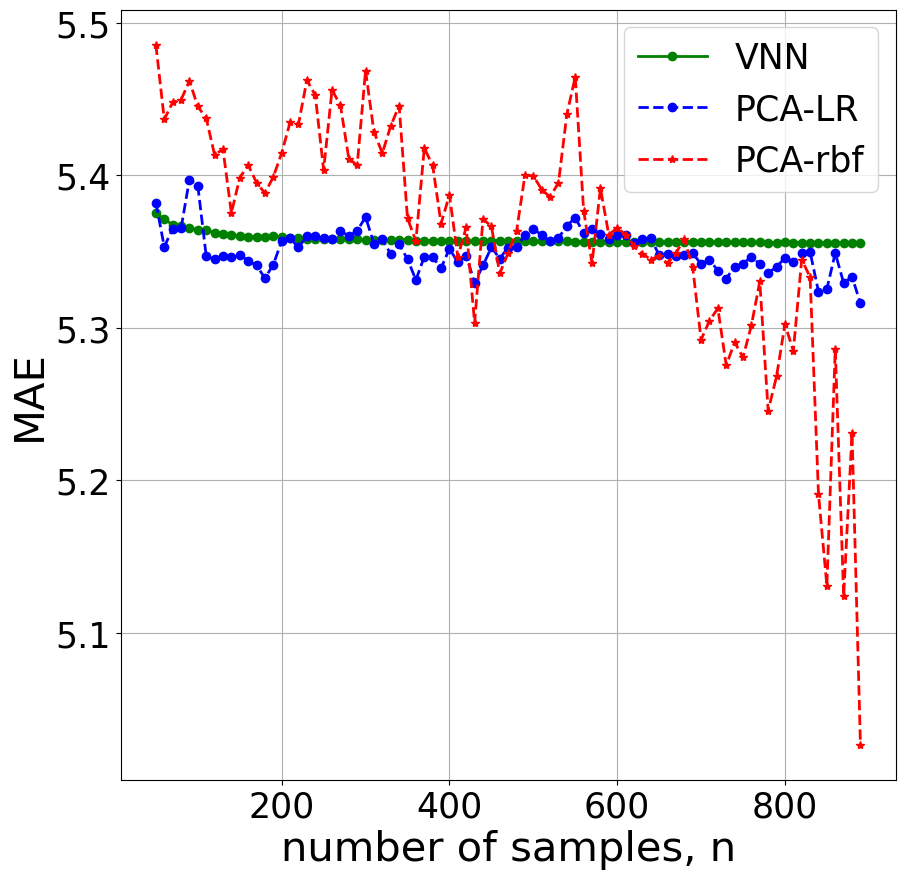

In [7]:

plt.figure(figsize=(10,10))
plt.plot(y,VNN_trainperf_MAE_all, 'go-',  linewidth=2, label = 'VNN')
plt.plot(y,PCA_trainperf_MAE_all, 'bo--',  linewidth=2, label = 'PCA-LR')
plt.plot(y,PCA_trainperf_MAE_all_rbf, 'r*--', linewidth=2, label = 'PCA-rbf')
plt.xticks(fontsize= 25)
plt.yticks(fontsize= 25)
plt.legend(fontsize=25)
plt.xlabel('number of samples, n', fontsize=30)
plt.ylabel('MAE', fontsize=30)
plt.grid()
plt.show()

# Plot stability performance for test set

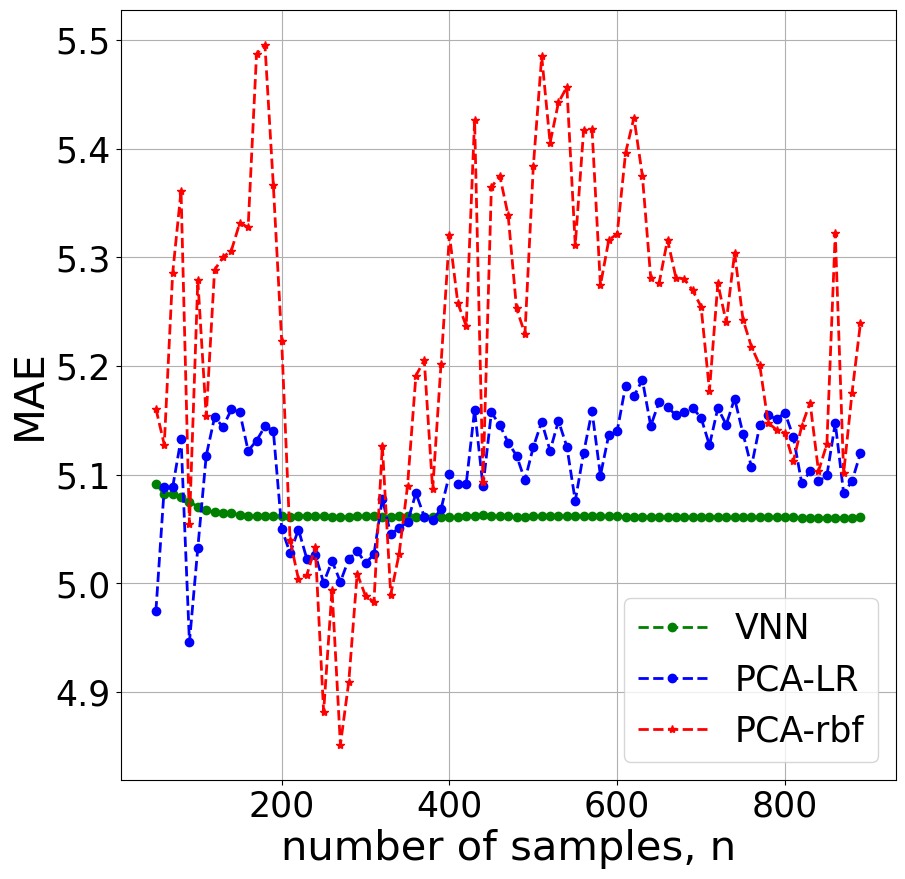

In [8]:

plt.figure(figsize=(10,10))
plt.plot(y,VNN_testperf_MAE_all, 'go--',  linewidth=2, label = 'VNN')
plt.plot(y,PCA_testperf_MAE_all, 'bo--',  linewidth=2, label = 'PCA-LR')
plt.plot(y,PCA_testperf_MAE_all_rbf, 'r*--', linewidth=2, label = 'PCA-rbf')
plt.xticks(fontsize= 25)
plt.yticks(fontsize= 25)
plt.legend(fontsize=25)
plt.xlabel('number of samples, n', fontsize=30)
plt.ylabel('MAE', fontsize=30)
plt.grid()
plt.show()